# RAPPORT EMBOLIES

# Introduction

Dans le domaine médical, la détection précoce des embolies est essentielle pour la prise en charge efficace des patients. Les signaux Doppler ultrasonores offrent une méthode précieuse pour cette tâche, mais leur analyse nécessite des techniques avancées pour distinguer les embolies du bruit. Ce rapport explore une série de méthodes d'analyse de signaux Doppler ultrasonores, de la détection de pics à la suppression d'artefacts, visant à améliorer la fiabilité du diagnostic des embolies.

## Sommaire

I. **Affichage du Signal**
   - Chargement du fichier audio WAV, affichage du signal enregistré (partie réelle), segmentation du signal et affichage de la partie réelle et imaginaire.

II. **Représentation en Fréquence & Affichage du Spectrogramme**
   - Calcul du spectre en fréquence, affichage du spectre en fréquence, calcul et affichage du spectrogramme.

III. **Analyse de l'Énergie par Époque**
   - Calcul de l'énergie par époque, affichage de l'énergie par époque.

IV. **Filtrage du Signal d'Énergie par Époque**
   - Correction de l'axe des temps, création et application du filtre passe-bas, soustraction du signal d'énergie par époque lissé.

V. **Suppression des Valeurs Aberrantes (Optionnel)**
   - Définition de la fonction remove_outliers, application de la fonction pour nettoyer les valeurs aberrantes, soustraction du signal d'énergie lissé pour obtenir uniquement le bruit.

VI. **Détection des Embolies**
   - Utilisation de la fonction find_peaks pour détecter les embolies, affichage des embolies détectées sur le signal d'énergie par époque, affichage du nombre total d'embolies détectées.

VII. **Extraction et Lissage de l'Enveloppe Négative**
   - Calcul des minima locaux, extraction des minima, interpolation pour lissage, affichage du signal original et de son enveloppe négative lissée.

VIII. **Détection des Embolies avec l'enveloppe négative**
   - Calcul de la distance, détection des pics, calcul des distances entre les pics et l'enveloppe, calcul de la moyenne des distances, affichage du signal original, de l'enveloppe et des pics détectés.

IX. **Détection des Embolies sur plusieurs itérations**
   - Fusion de pics voisins, itérations avec ajout de bruit aléatoire, analyse des pics stables, analyse des résultats.

X. **Suppression des Artefacts**
   - Artefacts dans les Signaux Doppler, approche de suppression des artefacts.

XI. **Détection des Pics dans le Signal d'Énergie Négatif avec Percentile**
   - Détection des pics, affichage des pics, enregistrement des positions.

XII. **Sélection des Pics Pertinents**
   - Tri des positions, définition de la fenêtre temporelle, sélection des pics, affichage des pics sélectionnés.


 # Bibliothèques

In [1]:
# Pour le calcul numérique et la manipulation de tableaux multidimensionnels.
import numpy as np

# Pour lire et écrire des fichiers audio au format WAV.
import scipy.io.wavfile as wav

# Pour le traçage de graphiques et de visualisations à partir de données.
import matplotlib.pyplot as plt

# Pour calculer le spectrogramme d'un signal audio.
from scipy.signal import spectrogram

# Pour générer une fenêtre de type Kaiser, utilisée dans le traitement du signal.
from scipy.signal import kaiser

# Pour générer une fenêtre de type Hamming, utilisée dans le traitement du signal.
from scipy.signal import hamming

# Pour concevoir et appliquer des filtres numériques.
from scipy.signal import butter, filtfilt

# Pour détecter les pics dans un signal.
from scipy.signal import find_peaks

# Pour effectuer la transformée de Hilbert d'un signal.
from scipy.signal import hilbert

# Pour l'interpolation de données.
from scipy.interpolate import interp1d

# I. Affichage du Signal

On charge un fichier audio WAV, représente son signal en temps, et affiche la partie réelle et imaginaire du signal en fonction du temps.

- **Chargement du fichier audio :** Le code utilise la bibliothèque `scipy.io.wavfile` pour charger le fichier audio WAV.
- **Affichage du signal enregistré (partie réelle) :** Le signal enregistré est représenté en fonction du temps, montrant l'amplitude en fonction du temps.
- **Segmentation du signal et affichage de la partie réelle et imaginaire :** Le signal est segmenté en époques de durée fixe, avec un chevauchement entre les époques. La partie réelle et imaginaire de chaque époque est affichée en fonction du temps.

Les étapes suivantes sont incluses dans cette section :
- Calcul de la durée totale du signal.
- Segmentation du signal en époques.
- Affichage de la partie réelle et imaginaire de chaque époque en fonction du temps.


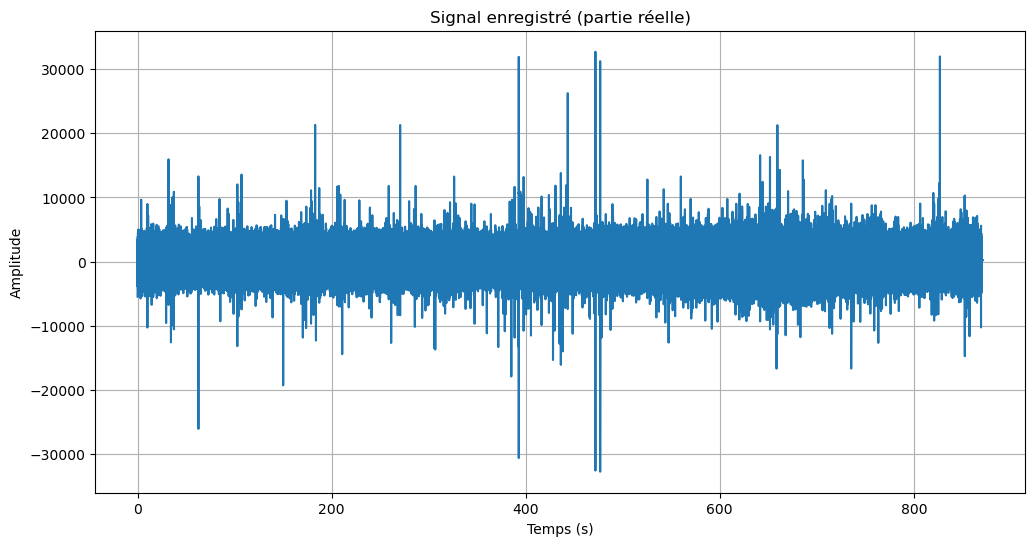

<Figure size 640x480 with 0 Axes>

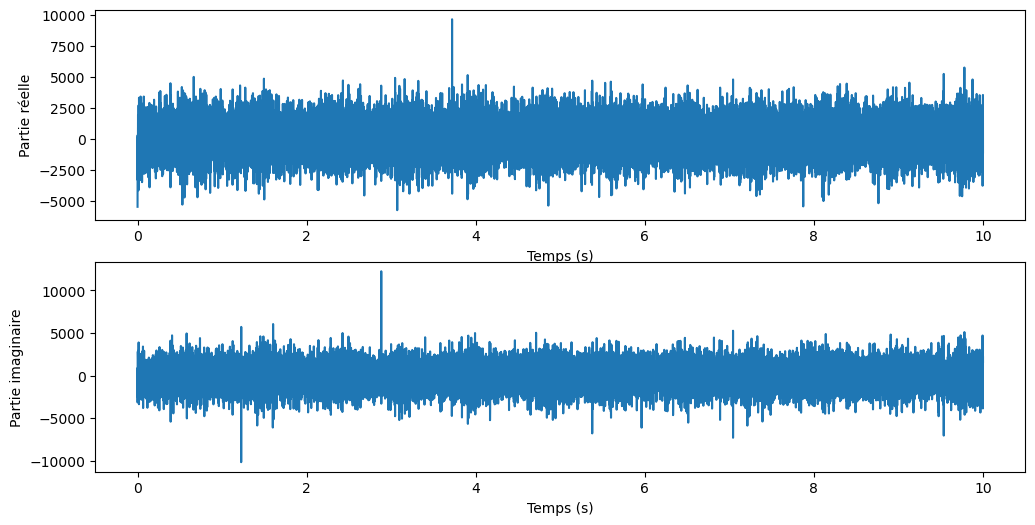

In [2]:
filename = 'T54_a.wav'
Fs, y = wav.read(filename)
X = y[:, 0] - 1j * y[:, 1]
Nmax = len(X)
TotalDuration = Nmax / Fs

# Code pour afficher le signal
plt.figure(figsize=(12, 6))
plt.plot(np.linspace(0, TotalDuration, Nmax), X.real)
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal enregistré (partie réelle)')
plt.grid(True)
plt.show()

Overlap = 80 / 100
Lwind = 64
Delay = round(Lwind - (Lwind * Overlap))
ED = 10  # EpoqueDuration
NObs = int(ED * Fs)
k = 1 # Changer la segmentation du signal 1=[0 10], 2=[11 20], etc
x = X[(k - 1) * NObs:k * NObs]
tx = np.linspace(0, ED, len(x))



plt.figure()
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(tx, np.real(x))
plt.ylabel('Partie réelle')
plt.xlabel('Temps (s)')

plt.subplot(2, 1, 2)
plt.plot(tx, np.imag(x))
plt.ylabel('Partie imaginaire')
plt.xlabel('Temps (s)')

plt.show()


# II. Représentation en Fréquence & Affichage du Spectrogramme

On calcule le spectre en fréquence du signal et affiche la magnitude du spectre en fonction de la fréquence.

- **Calcul du spectre en fréquence :** Le code utilise la transformée de Fourier pour calculer le spectre en fréquence du signal.
- **Affichage du spectre en fréquence :** Le spectre en fréquence est divisé en partie positive et négative, et la magnitude est représentée en fonction de la fréquence pour chaque partie.

Les étapes suivantes sont incluses dans cette section :
- Calcul du spectre en fréquence pour la partie positive et négative.
- Affichage de la magnitude du spectre en fonction de la fréquence pour chaque partie.

On utilise la fonction `specgram` de `scipy.signal` pour calculer et afficher le spectrogramme du signal.

- **Calcul du spectrogramme :** Le spectrogramme du signal est calculé à l'aide de la fonction `specgram`, en spécifiant les paramètres tels que la longueur de la fenêtre, le chevauchement et la forme de la fenêtre.
- **Affichage du spectrogramme :** Le spectrogramme est affiché, montrant l'évolution de la magnitude en fonction du temps et de la fréquence.


<Figure size 640x480 with 0 Axes>

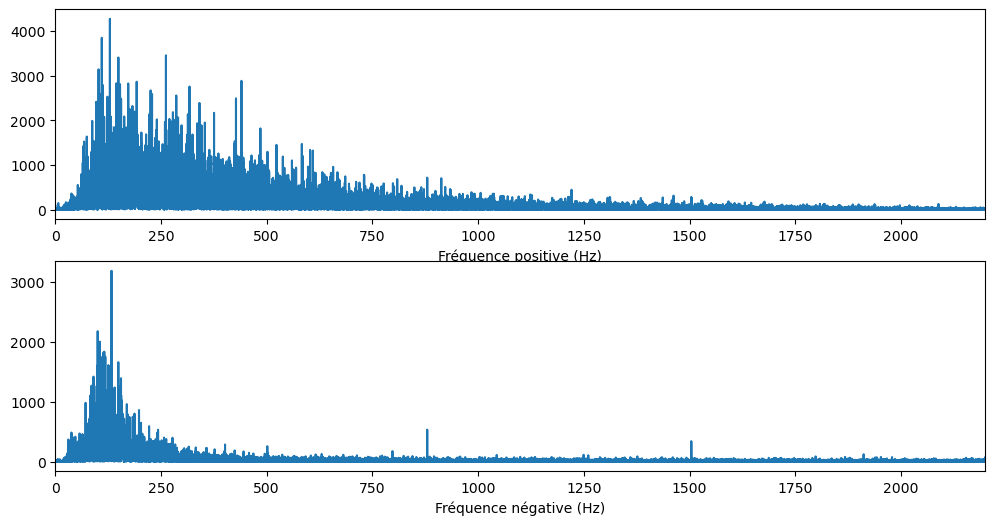

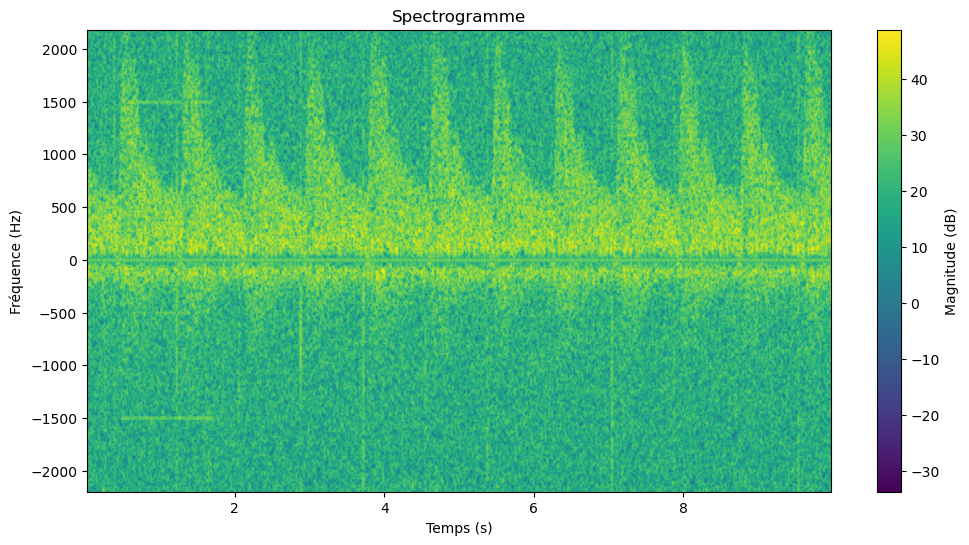

In [3]:
Xspec = np.fft.fft(x - np.mean(x)) / len(x)
Xspec_fp = np.abs(Xspec[:len(Xspec) // 2]) ** 2
fp = np.linspace(0, Fs / 2, len(Xspec_fp))

Xspec_fn = np.flipud(np.abs(Xspec[len(Xspec) // 2 + 1:]) ** 2)
fn = np.linspace(0, Fs / 2, len(Xspec_fn))

plt.figure()
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(fp, Xspec_fp)
plt.xlabel('Fréquence positive (Hz)')
plt.xlim([0, Fs / 2])

plt.subplot(2, 1, 2)
plt.plot(fn, Xspec_fn)
plt.xlabel('Fréquence négative (Hz)')
plt.xlim([0, Fs / 2])

plt.show()

# Affichage du spectrogramme
plt.figure(figsize=(12, 6))
plt.specgram(x, NFFT=256, Fs=Fs, window=kaiser(256, 5), noverlap=220)
plt.ylabel('Fréquence (Hz)')
plt.xlabel('Temps (s)')
plt.colorbar(label='Magnitude (dB)')
plt.title('Spectrogramme')
plt.show()



# III. Analyse de l'Énergie par Époque

Ici, on calcule l'énergie par époque du signal.

- **Calcul de l'énergie par époque :** Le code segmente le signal en époques de taille fixe et calcule l'énergie de chaque époque en appliquant une fenêtre de Hamming sur le spectre de Fourier du signal.
- **Affichage de l'énergie par époque :** L'énergie de chaque époque est représentée en fonction du temps.


<Figure size 640x480 with 0 Axes>

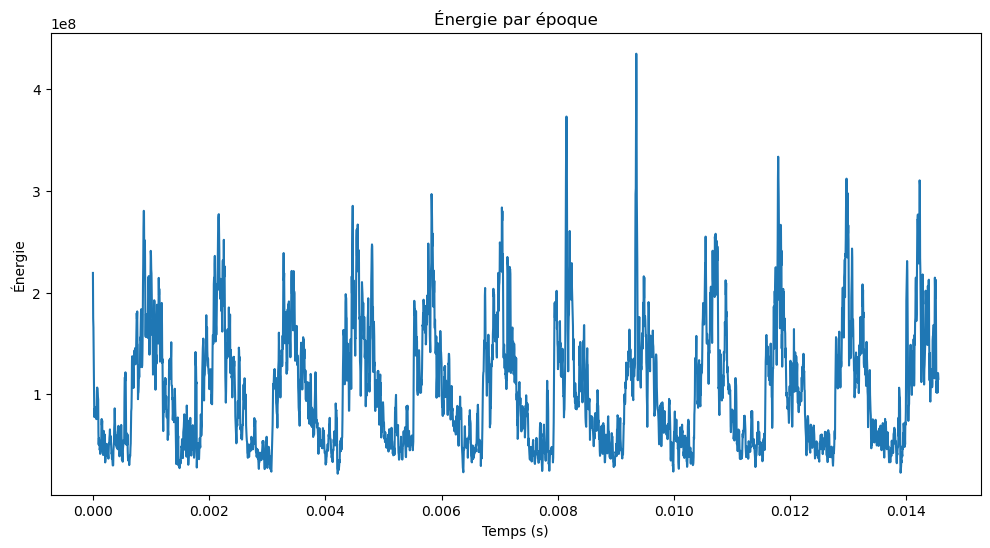

In [4]:
EpoqueDuration = Lwind / Fs

l = 1
Energy = []
while (l - 1) * Delay + Lwind < NObs:
    x_wind = x[(l - 1) * Delay:l * Delay + Lwind]
    S = np.abs(np.fft.fft(x_wind, 512))
    FrpPos = np.arange(len(S) // 2)
    FrqNeg = np.arange(len(S) // 2, len(S))
    Energy.append([
        np.sum((S[FrpPos] * hamming(len(FrpPos))) ** 2) / len(FrpPos),
        #np.sum((S[FrqNeg] * hamming(len(FrqNeg))) ** 2) / len(FrqNeg)
    ])
    l += 1

Energy = np.array(Energy)
Sgl = Energy[:, 0]
tx = np.linspace(0, EpoqueDuration, len(Sgl))

plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(tx, Sgl)
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Énergie par époque')
plt.show()


# IV. Filtrage du Signal d'Énergie par Époque

Dans cette section, plusieurs opérations sont effectuées sur le signal d'énergie par époque.

- **Correction de l'Axe des Temps :** L'axe des temps est recalculé pour correspondre à l'échelle temporelle correcte.
- **Création du Filtre Passe-Bas :** Un filtre passe-bas Butterworth est créé pour lisser le signal d'énergie par époque. Les paramètres tels que l'ordre du filtre et la fréquence de coupure sont spécifiés.
- **Application du Filtre Passe-Bas :** Le filtre passe-bas est appliqué à l'énergie par époque pour lisser le signal.
- **Détection des Pics et du Bruit :** Les points supérieurs au lissage sont identifiés comme étant des pics ou du bruit.


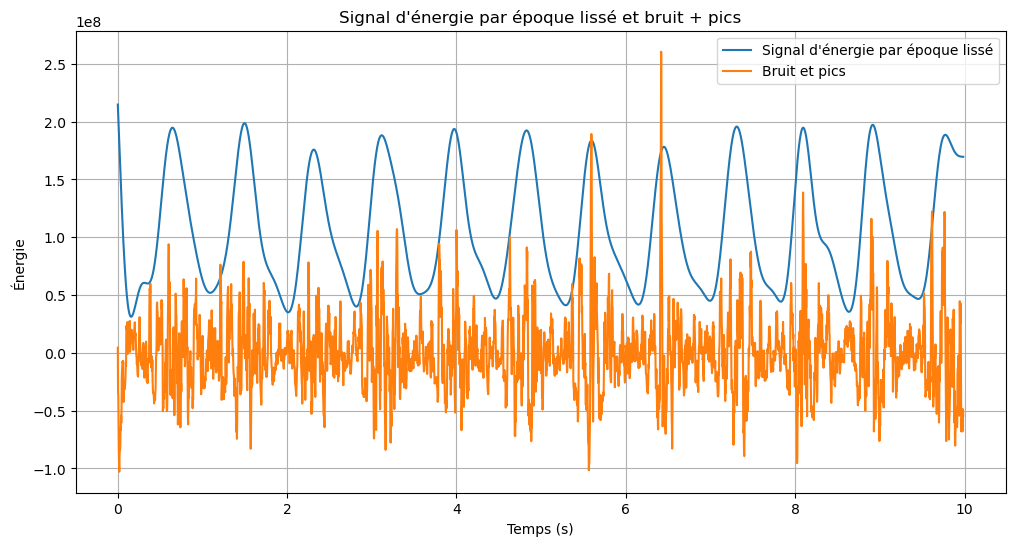

In [5]:
# Correction de l'axe des temps pour le dernier plot
epoch_times = np.arange(len(Sgl)) * (Delay / Fs)

# Définition des paramètres du filtre passe-bas
order = 6  # Ordre du filtre
cutoff_freq = 0.01  # Fréquence de coupure du filtre (en Hz)

# Création du filtre passe-bas
b, a = butter(order, cutoff_freq, fs=1)

# Application du filtre passe-bas à l'énergie par époque pour lisser le signal
smoothed_energy = filtfilt(b, a, Sgl)

# Soustraction du signal d'énergie par époque lissé du signal d'énergie par époque original
noise_and_peaks = Sgl - smoothed_energy

plt.figure(figsize=(12, 6))
# Affichage des points supérieurs au lissage
plt.plot(epoch_times, smoothed_energy, label='Signal d\'énergie par époque lissé')
plt.plot(epoch_times, noise_and_peaks, label='Bruit et pics')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé et bruit + pics')
plt.legend()
plt.grid(True)
plt.show()

# V. Suppression des Valeurs Aberrantes (Optionnel)

Cette partie de code vise à un signal sans les pics imposants en utilisant une méthode de suppression des valeurs aberrantes.

- **Fonction pour Supprimer les Valeurs Aberrantes :** Une fonction `remove_outliers` est définie pour supprimer les valeurs aberrantes du signal en fonction d'un seuil donné.
- **Application de la Fonction :** La fonction `remove_outliers` est appliquée au signal de bruit et de pics pour nettoyer les valeurs aberrantes.
- **Soustraction du Signal d'Énergie lissé :** Le signal d'énergie lissé est soustrait du signal de bruit et de pics pour obtenir uniquement le bruit sans les pics.


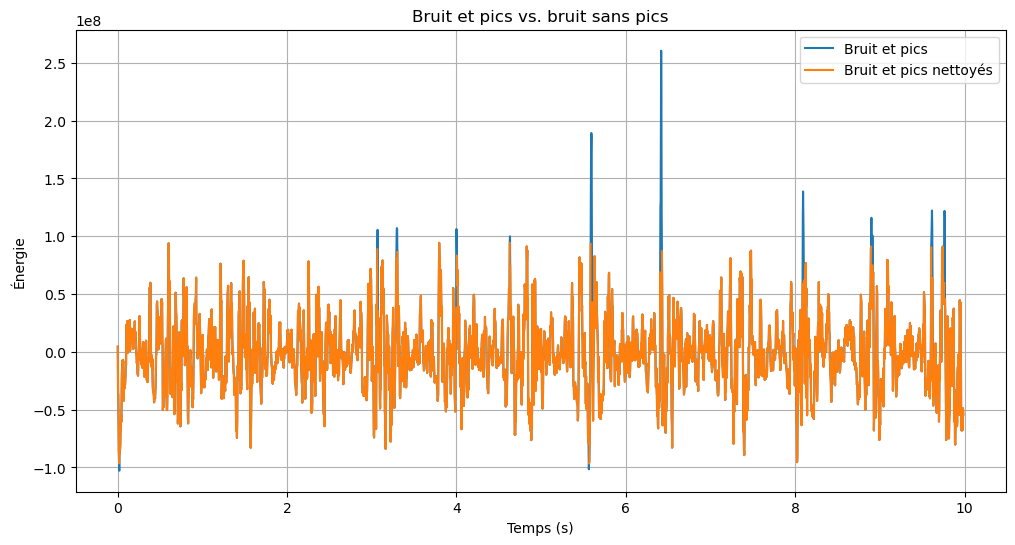

In [6]:
# Fonction pour supprimer les valeurs aberrantes (équivalent de remoutlier de Matlab)
def remove_outliers(signal, threshold=3):
    mean_signal = np.mean(signal)
    std_signal = np.std(signal)
    outlier_indices = np.abs(signal - mean_signal) > threshold * std_signal
    clean_signal = signal.copy()
    clean_signal[outlier_indices] = np.nan
    return clean_signal

# Appliquer la fonction remove_outliers au signal "bruits et pics"
clean_noise_and_peaks = remove_outliers(noise_and_peaks)

# Soustraire le signal d'énergie par époque lissé du signal d'énergie par époque original pour obtenir le bruit sans les pics
clean_noise = noise_and_peaks - smoothed_energy

# Afficher les signaux
plt.figure(figsize=(12, 6))

plt.plot(epoch_times, noise_and_peaks, label='Bruit et pics')
plt.plot(epoch_times, clean_noise_and_peaks, label='Bruit et pics nettoyés')

plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Bruit et pics vs. bruit sans pics')
plt.legend()
plt.grid(True)
plt.show()


# VI. Détection des Embolies

Dans cette section, une première approche de détection des embolies est réalisée.

- **Détection des Pics :** La fonction `find_peaks` est utilisée pour détecter les pics dans le signal de bruit et de pics. Un seuil est défini pour filtrer les pics significatifs.
- **Affichage des Résultats :** Les embolies détectées sont marquées sur le signal d'énergie par époque pour visualisation.
- **Affichage du Nombre d'Embolies :** Le nombre total d'embolies détectées est affiché.



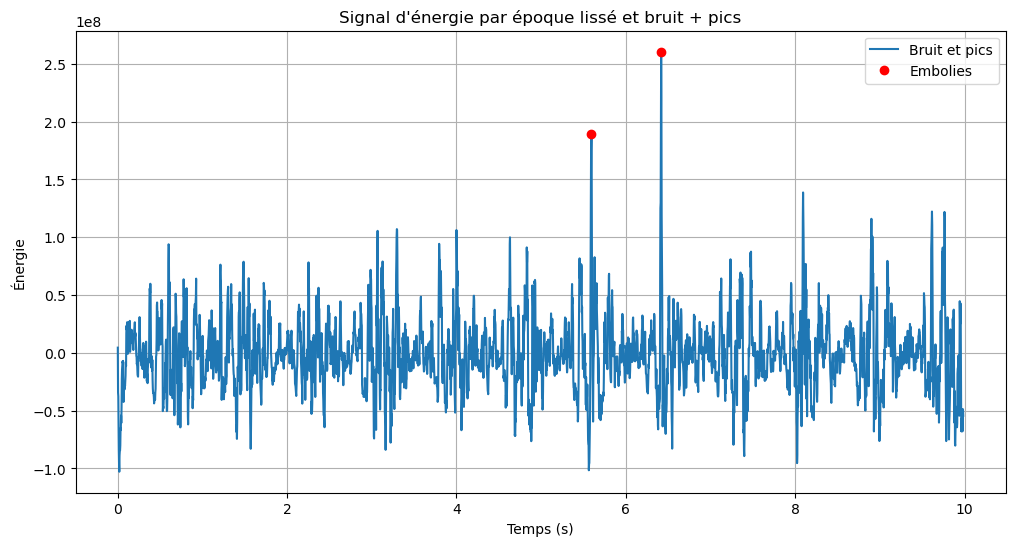

Nombre d'embolie : 2


In [7]:
seuil = 1.5e8
peaks, _ = find_peaks(noise_and_peaks, height=seuil)
nombre_embolie = len(peaks)

# Afficher les résultats avec les embolies détectées
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, noise_and_peaks, label='Bruit et pics')
plt.plot(epoch_times[peaks], noise_and_peaks[peaks], 'ro', label='Embolies')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé et bruit + pics')
plt.legend()
plt.grid(True)
plt.show()

# Afficher le nombre d'embolies
print("Nombre d'embolie :", nombre_embolie)

# VII. Extraction et Lissage de l'Enveloppe Négative

Dans cette section, nous procédons à l'extraction et au lissage de l'enveloppe négative du signal. Cela nous permet de détecter les embolies de manière plus précise en identifiant les creux significatifs dans le signal.

- **Calcul des Minima Locaux :** Tout d'abord, on calcule les minima locaux sur le signal inversé. Cela nous permet de repérer les creux importants dans le signal qui peuvent correspondre à des embolies.

- **Extraction des Minima :** Nous extrayons ensuite les valeurs minimales ainsi que les indices correspondants à partir des minima locaux trouvés. Ces valeurs nous fournissent l'enveloppe négative brute du signal.

- **Interpolation pour Lissage :** Pour obtenir une enveloppe négative plus lisse et continue, nous utilisons une interpolation cubique des valeurs minimales extraites. Cela nous donne une courbe lissée qui représente mieux l'enveloppe négative du signal.

- **Affichage :** Enfin, nous affichons le signal original ainsi que son enveloppe négative lissée. Cela nous permet de visualiser les creux détectés et d'évaluer la précision de notre méthode de détection des embolies.


<Figure size 640x480 with 0 Axes>

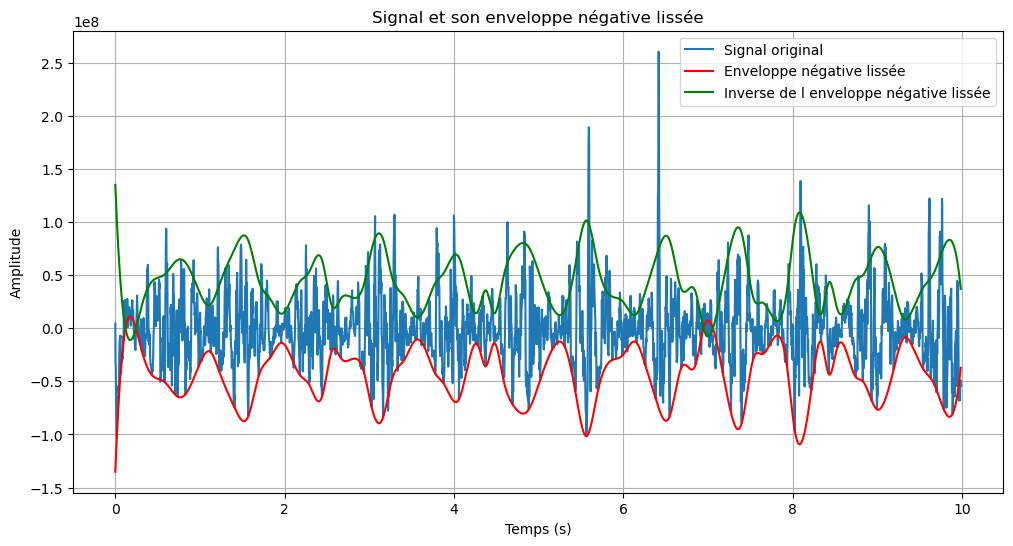

In [8]:
# Calcul des minima locaux pour l'enveloppe négative
min_peaks, _ = find_peaks(-noise_and_peaks.real, distance=30, width=4, prominence=2)  # Trouver les pics sur le signal inversé

# Extraction des valeurs minimales et des indices correspondants
negative_envelope = noise_and_peaks.real[min_peaks]
tx_negative_envelope = tx[min_peaks]

# Interpolation pour obtenir une enveloppe lissée
interp_func = interp1d(tx_negative_envelope, negative_envelope, kind='cubic', fill_value="extrapolate")
final=smooth_negative_envelope = interp_func(tx)

# Affichage de l'enveloppe négative lissée
plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, noise_and_peaks.real, label='Signal original')
plt.plot(epoch_times, smooth_negative_envelope, 'r', label='Enveloppe négative lissée')
plt.plot(epoch_times, -smooth_negative_envelope, 'g', label='Inverse de l enveloppe négative lissée')
plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal et son enveloppe négative lissée')
plt.legend()
plt.grid(True)
plt.show()


# VIII. Extraction et Lissage de l'Enveloppe Négative

Dans cette étape, on procède à l'extraction et au lissage de l'enveloppe négative du signal. Cela nous permet de détecter les embolies de manière plus précise en identifiant les creux significatifs dans le signal.

- **Calcul de la Distance :** On calcule la différence entre le signal d'énergie par époque et son enveloppe négative lissée.
- **Détection des Pics :** On utilise la fonction `find_peaks` pour trouver les indices où la distance dépasse un seuil spécifique, ce qui correspond aux pics significatifs.
- **Calcul des Distances entre les Pics et l'Enveloppe :** On calcule les distances entre les pics détectés et la courbe d'enveloppe négative lissée.
- **Calcul de la Moyenne des Distances :** On calcule la moyenne des distances pour définir un seuil.
- **Affichage :** On affiche le signal original, son enveloppe négative lissée et les pics détectés qui dépassent le seuil par rapport à l'enveloppe.


<Figure size 640x480 with 0 Axes>

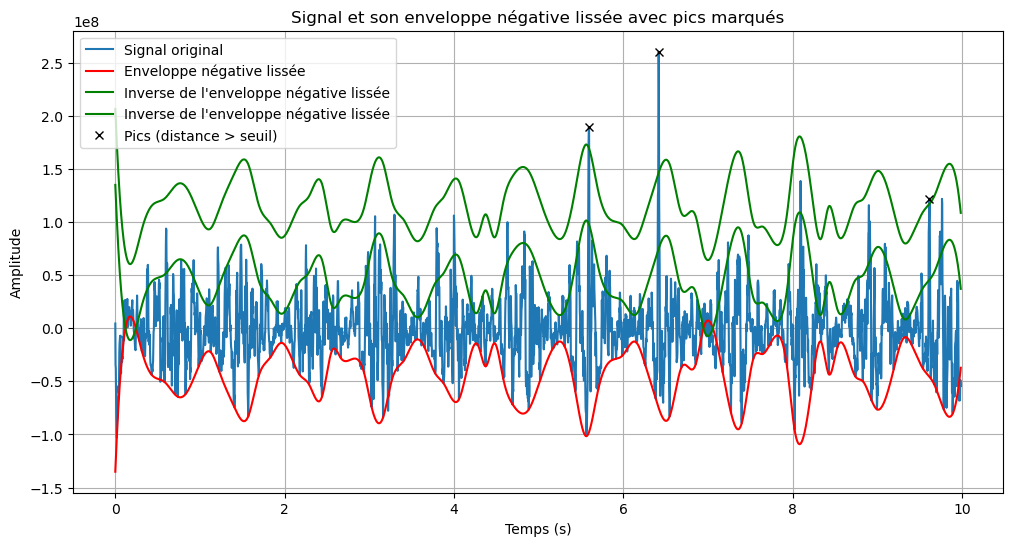

In [9]:
# Calcul de la distance entre noise_and_peaks et l'enveloppe négative lissée
distance = noise_and_peaks.real - smooth_negative_envelope

# Trouver les indices où la distance dépasse le seuil
peaks, properties = find_peaks(distance, height=-smooth_negative_envelope)

# Calculer les distances entre les pics détectés et la courbe d'enveloppe négative lissée
distances_pics_envelope = np.abs(distance[peaks])

# Calculer la moyenne des distances
seuil = np.mean(distances_pics_envelope)

# Calcul de la distance entre noise_and_peaks et l'enveloppe négative lissée
distance = noise_and_peaks.real + smooth_negative_envelope

# Trouver les indices où la distance dépasse le seuil
peaks, _ = find_peaks(distance, height=seuil)

# Affichage du signal, de l'enveloppe négative lissée, et des pics
plt.figure()
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, noise_and_peaks.real, label='Signal original')
plt.plot(epoch_times, smooth_negative_envelope, 'r', label='Enveloppe négative lissée')
plt.plot(epoch_times, -smooth_negative_envelope, 'g', label='Inverse de l\'enveloppe négative lissée')
plt.plot(epoch_times, -smooth_negative_envelope+seuil, 'g', label='Inverse de l\'enveloppe négative lissée')

# Ajouter les pics au graphique
plt.plot(epoch_times[peaks], noise_and_peaks.real[peaks], 'kx', label='Pics (distance > seuil)')

plt.xlabel('Temps (s)')
plt.ylabel('Amplitude')
plt.title('Signal et son enveloppe négative lissée avec pics marqués')
plt.legend()
plt.grid(True)
plt.show()

# IX. Détection des Embolies avec un du bruit sur plusieurs itérations 

Dans cette section, on vise à détecter et à fusionner les pics significatifs dans le signal d'énergie par époque, ce qui nous permettra d'identifier les embolies de manière plus robuste.

- **Fusion de Pics Voisins :** On commence par créer une liste pour enregistrer les positions de chaque pic détecté. Ensuite, on définit une fonction `merge_close_peaks` pour fusionner les pics voisins. Cette fonction prend en compte une distance seuil entre les pics, et si deux pics sont trop proches, on les fusionne en prenant la moyenne de leurs positions. Cette étape garantit que les pics trop proches les uns des autres sont regroupés en un seul.

- **Itérations :** On effectue cette fusion de pics sur un certain nombre d'itérations (200 dans cet exemple). À chaque itération, on ajoute un bruit aléatoire stochastique au signal pour introduire de la variabilité. L'idée derrière est de savoir si les pics détectés (embolies) sont bien réelles et ne sont pas des pics inutiles. Ensuite, on calcule l'énergie par époque, l'enveloppe négative, et on détecte les pics significatifs comme précédemment expliqué.

- **Analyse des Pics :** Une fois les pics détectés pour chaque itération, on calcule le nombre de travers toutes les itérations. Cela permet de déterminer quels pics sont les plus stables et donc les plus significatifs.

- **Analyse des Résultats :** On observe alors les positions de chaque pic dans le temps par rapport au nombre d'itérations où le pic est apparu. En fixant un seuil (dans cet exemple, la moitié du nombre total d'itérations), on identifie les pics qui ont été détectés de manière stable à travers les itérations. Ces pics qui dépassent le seuil sont considérés comme des embolies. Le nombre d'embolies ainsi que leurs positions sont alors affichés.

Cette approche nous permet d'identifier les embolies de manière plus robuste en prenant en compte leur stabilité à travers différentes itérations du processus de détection. Cela nous aide à réduire les faux positifs et à obtenir une détection plus fiable.



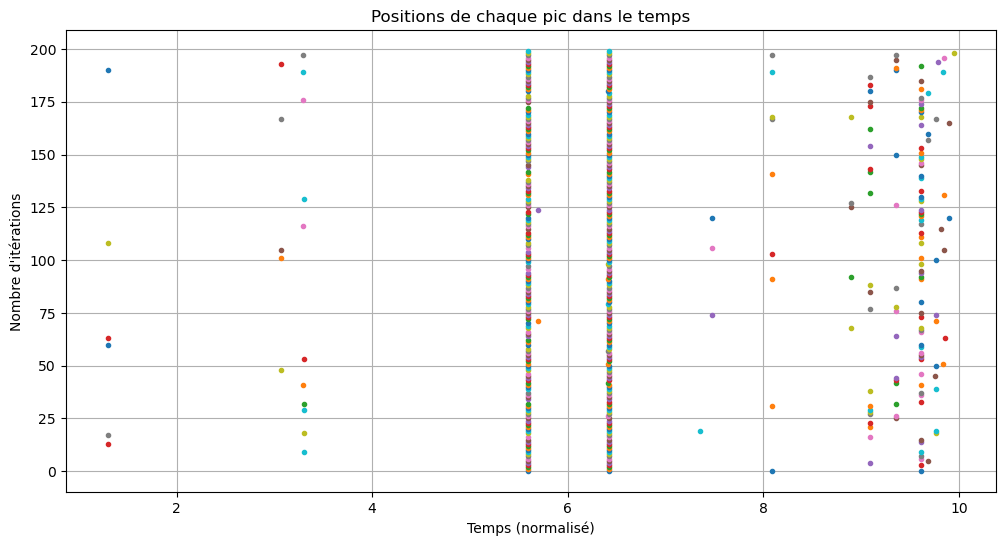

Nombre d'embolies: 2
Positions des embolies: [4.957025920873124, 5.908822191905412]


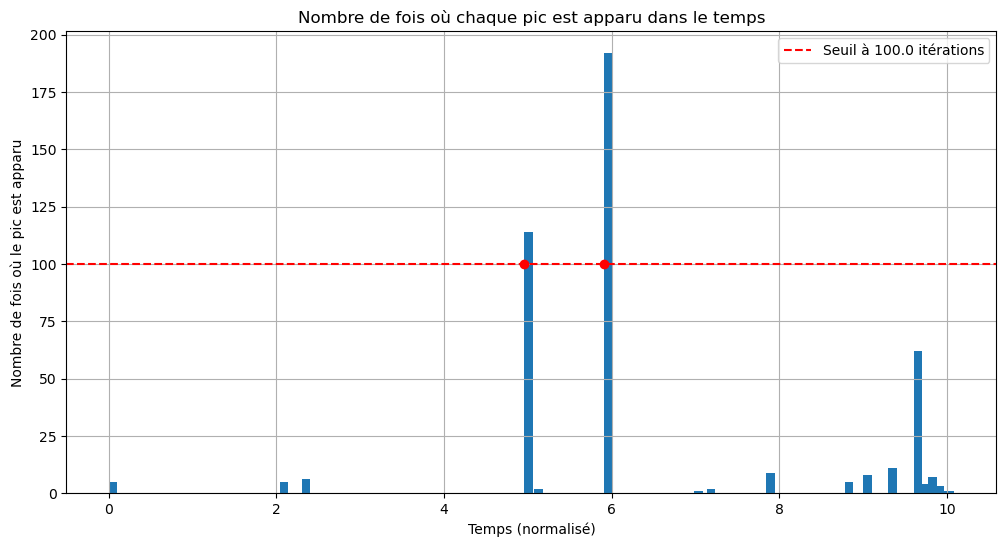

In [10]:
# Liste pour enregistrer les positions de chaque pic
pic_positions = []

iteration = 200 # Nombre d'itérations

# Fonction pour fusionner les pics voisins
def merge_close_peaks(peaks, distance_threshold):
    if len(peaks) == 0:
        return peaks
    merged_peaks = [peaks[0]]
    for peak in peaks[1:]:
        if peak - merged_peaks[-1] <= distance_threshold:
            merged_peaks[-1] = (merged_peaks[-1] + peak) // 2
        else:
            merged_peaks.append(peak)
    return np.array(merged_peaks)

for _ in range(iteration):  # Boucle sur 200 itérations
    # Ajouter un bruit aléatoire stochastique à x
    noise_level = np.std(np.real(x)) * 0.35  # Niveau de bruit
    random_noise = np.random.normal(0, noise_level, len(x))
    v = x + random_noise
    
    Xspec = np.fft.fft(v - np.mean(v)) / len(x)
    Xspec_fp = np.abs(Xspec[:len(Xspec) // 2]) ** 2
    fp = np.linspace(0, Fs / 2, len(Xspec_fp))

    Xspec_fn = np.flipud(np.abs(Xspec[len(Xspec) // 2 + 1:]) ** 2)
    fn = np.linspace(0, Fs / 2, len(Xspec_fn))

    EpoqueDuration = Lwind / Fs

    l = 1
    Energy = []
    while (l - 1) * Delay + Lwind < NObs:
        x_wind = v[(l - 1) * Delay:l * Delay + Lwind]
        S = np.abs(np.fft.fft(x_wind, 512))
        FrpPos = np.arange(len(S) // 2)
        FrqNeg = np.arange(len(S) // 2, len(S))
        Energy.append([
            np.sum((S[FrpPos] * hamming(len(FrpPos))) ** 2) / len(FrpPos),
        ])
        l += 1

    Energy = np.array(Energy)
    Sgl = Energy[:, 0]
    tx = np.linspace(0, EpoqueDuration, len(Sgl))

    order = 6  # Ordre du filtre
    cutoff_freq = 0.01  # Fréquence de coupure du filtre (en Hz)

    # Création du filtre passe-bas
    b, a = butter(order, cutoff_freq, fs=1)

    # Application du filtre passe-bas à l'énergie par époque pour lisser le signal
    smoothed_energy = filtfilt(b, a, Sgl)

    # Soustraction du signal d'énergie par époque lissé du signal d'énergie par époque original
    noise_and_peaks = Sgl - smoothed_energy
    
    def remove_outliers(signal, threshold=3):
        mean_signal = np.mean(signal)
        std_signal = np.std(signal)
        outlier_indices = np.abs(signal - mean_signal) > threshold * std_signal
        clean_signal = signal.copy()
        clean_signal[outlier_indices] = np.nan
        return clean_signal

    # Appliquer la fonction remove_outliers au signal "bruits et pics"
    clean_noise_and_peaks = remove_outliers(noise_and_peaks)

    # Soustraire le signal d'énergie par époque lissé du signal d'énergie par époque original pour obtenir le bruit sans les pics
    clean_noise = noise_and_peaks - smoothed_energy

    embolie_indices = np.where(clean_noise_and_peaks > noise_and_peaks)[0]
    nombre_embolie = len(embolie_indices)

    # Calcul des minima locaux pour l'enveloppe négative
    min_peaks, _ = find_peaks(-noise_and_peaks.real, distance=20, width=5)

    # Extraction des valeurs minimales et des indices correspondants
    negative_envelope = noise_and_peaks.real[min_peaks]
    tx_negative_envelope = tx[min_peaks]

    # Interpolation pour obtenir une enveloppe lissée
    interp_func = interp1d(tx_negative_envelope, negative_envelope, kind='cubic', fill_value="extrapolate")
    smooth_negative_envelope = interp_func(tx)
    
    # Calcul de la distance entre noise_and_peaks et l'enveloppe négative lissée
    distance = noise_and_peaks.real - smooth_negative_envelope

    # Trouver les indices où la distance dépasse le seuil
    peaks, properties = find_peaks(distance, height=-smooth_negative_envelope)

    # Calculer les distances entre les pics détectés et la courbe d'enveloppe négative lissée
    distances_pics_envelope = np.abs(distance[peaks])

    # Calculer la moyenne des distances
    seuil = np.mean(distances_pics_envelope)

    # Calcul de la distance entre noise_and_peaks et l'enveloppe négative lissée
    distance = noise_and_peaks.real + smooth_negative_envelope

    # Trouver les indices où la distance dépasse le seuil
    peaks, _ = find_peaks(distance, height=seuil)

    # Fusionner les pics voisins
    distance_threshold = 200  # Distance en indices d'échantillon pour fusionner les pics
    merged_peaks = merge_close_peaks(peaks, distance_threshold)
    
    # Enregistrer les positions de chaque pic
    pic_positions.append(merged_peaks)

# Calculer le nombre de fois où chaque position de pic est apparue
position_counts, bin_edges = np.histogram(np.concatenate(pic_positions), bins=len(tx))

# Initialiser la variable pour le nombre d'embolies
nombre_embolies = 0
embolies_positions = []

plt.figure(figsize=(12, 6))
for i, positions in enumerate(pic_positions):
    plt.plot(epoch_times[positions], [i] * len(positions), '.')
plt.xlabel('Temps (normalisé)')
plt.ylabel('Nombre d\'itérations')
plt.title('Positions de chaque pic dans le temps')
plt.grid(True)
plt.show()

# Définir le seuil d'itérations
seuil_iterations = iteration/2

# Vérifier les positions des pics qui dépassent le seuil et les enregistrer
for i, count in enumerate(position_counts):
    if count > seuil_iterations:
        nombre_embolies += 1
        embolies_positions.append(epoch_times[i])

print(f"Nombre d'embolies: {nombre_embolies}")
print(f"Positions des embolies: {embolies_positions}")

# Afficher les positions de chaque pic dans le temps par rapport au nombre de fois où le pic est apparu
plt.figure(figsize=(12, 6))
plt.bar(epoch_times, position_counts, width=0.1, align='edge')

# Ajouter une ligne horizontale à la position du seuil (nombre d'itérations)
plt.axhline(y=seuil_iterations, color='red', linestyle='--', label=f'Seuil à {seuil_iterations} itérations')

# Ajouter des petits cercles en haut des barres qui dépassent le seuil
for embolie_pos in embolies_positions:
    plt.plot(embolie_pos, seuil_iterations, 'ro')

plt.xlabel('Temps (normalisé)')
plt.ylabel('Nombre de fois où le pic est apparu')
plt.title('Nombre de fois où chaque pic est apparu dans le temps')
plt.legend()
plt.grid(True)
plt.show()


# X. Détection et à la Suppression des Artefacts

Dans cette section, nous abordons les artefacts couramment observés dans les signaux Doppler, tels que le mouvement du patient et les fluctuations dues au déplacement des globules rouges. Nous présentons ensuite une approche visant à éliminer ces artefacts en analysant spécifiquement la partie négative du signal.

### Artefacts dans les Signaux Doppler

Les signaux Doppler peuvent être sujets à divers artefacts, notamment :
- **Mouvement du Patient :** Les mouvements respiratoires ou les changements de position peuvent entraîner des variations dans le signal.
- **Fluctuations des Globules Rouges :** Les mouvements des globules rouges dans les vaisseaux sanguins peuvent causer des fluctuations, surtout dans les zones de turbulence du flux sanguin.
- **Réflexions Multiples :** Lorsque l’onde ultrasonore se propage dans le tissu, elle peut être réfléchie plusieurs fois avant de revenir au capteur. Ces réflexions multiples peuvent créer des interférences et des artefacts dans le signal Doppler.
- **Effets de Bord :** Les bords des structures anatomiques, tels que les parois des vaisseaux sanguins, peuvent provoquer des réflexions et des distorsions du signal. Ces effets de bord peuvent entraîner des artefacts.
- **Effets de Gain :** Le gain (amplification) appliqué au signal peut également jouer un rôle. Un gain excessif peut amplifier les bruits et les artefacts, tandis qu’un gain insuffisant peut masquer des informations importantes.
- **Positionnement du Capteur :** La position du capteur ultrasonore sur le corps du patient peut influencer la qualité du signal. Un mauvais positionnement peut entraîner des artefacts.
- **Interférences Électromagnétiques :** Les interférences électromagnétiques provenant d’autres équipements médicaux ou d’objets environnants peuvent perturber le signal Doppler.

### Approche de Suppression des Artefacts

Une approche courante pour éliminer les artefacts consiste à analyser séparément les parties positives et négatives du signal. Dans cette section, nous nous concentrons sur la partie négative du signal, car la présence de pics dans cette région peut indiquer la présence d'artefacts.

Pour l'instant on répète le même schéma qu'au début mais avec la partie nègative du signal pour ne pas avoir de problème d'accumulation  avec les signaux du début...




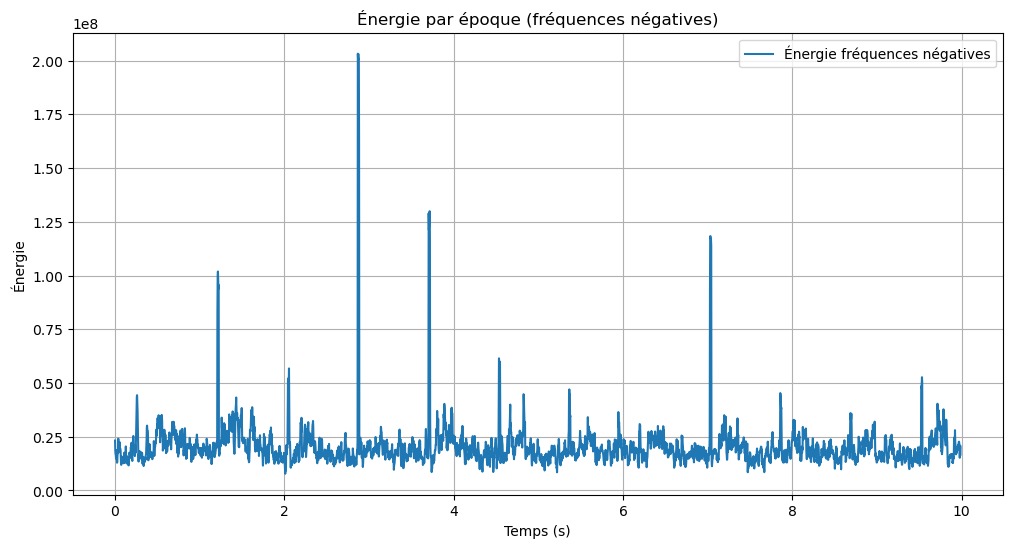

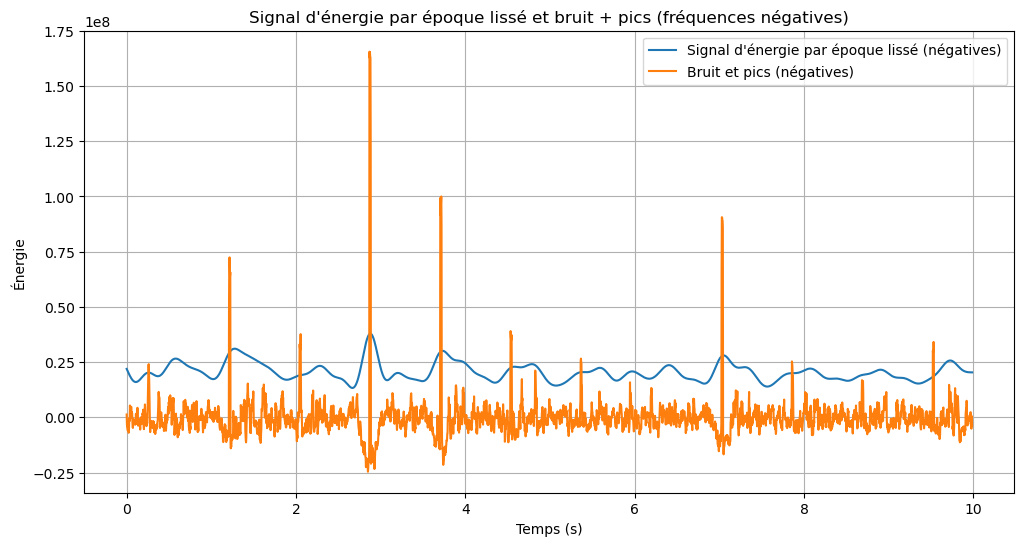

In [11]:
filename = 'T54_a.wav'
Fs, y = wav.read(filename)
X = y[:, 0] - 1j * y[:, 1]
Nmax = len(X)
TotalDuration = Nmax / Fs

Overlap = 80 / 100
Lwind = 64
Delay = round(Lwind - (Lwind * Overlap))
ED = 10  # EpoqueDuration
NObs = int(ED * Fs)
k = 1 # Changer la segmentation du signal 1=[0 10], 2=[11 20], etc
x = X[(k - 1) * NObs:k * NObs]
tx = np.linspace(0, ED, len(x))

Xspec = np.fft.fft(x - np.mean(x)) / len(x)
Xspec_fp = np.abs(Xspec[:len(Xspec) // 2]) ** 2
fp = np.linspace(0, Fs / 2, len(Xspec_fp))

Xspec_fn = np.flipud(np.abs(Xspec[len(Xspec) // 2 + 1:]) ** 2)
fn = np.linspace(0, Fs / 2, len(Xspec_fn))

# Calcul de l'énergie par époque pour les fréquences positives et négatives
EpoqueDuration = Lwind / Fs
l = 1
Energy_neg = []
Energy_pos = []

while (l - 1) * Delay + Lwind < NObs:
    x_wind = x[(l - 1) * Delay:l * Delay + Lwind]
    S = np.abs(np.fft.fft(x_wind, 512))
    FrpPos = np.arange(len(S) // 2)
    FrqNeg = np.arange(len(S) // 2, len(S))
    Energy_pos.append(np.sum((S[FrpPos] * hamming(len(FrpPos))) ** 2) / len(FrpPos))
    Energy_neg.append(np.sum((S[FrqNeg] * hamming(len(FrqNeg))) ** 2) / len(FrqNeg))
    l += 1

Energy_pos = np.array(Energy_pos)
Energy_neg = np.array(Energy_neg)

# Correction de l'axe des temps
epoch_times = np.arange(len(Energy_pos)) * (Delay / Fs)

# Affichage de l'énergie par époque pour les fréquences négatives
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, Energy_neg, label='Énergie fréquences négatives')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Énergie par époque (fréquences négatives)')
plt.legend()
plt.grid(True)
plt.show()

# Définition des paramètres du filtre passe-bas
order = 6  # Ordre du filtre
cutoff_freq = 0.01  # Fréquence de coupure du filtre (en Hz)

# Création du filtre passe-bas
b, a = butter(order, cutoff_freq, fs=1)

# Application du filtre passe-bas à l'énergie par époque pour lisser le signal pour les fréquences négatives
smoothed_energy_neg = filtfilt(b, a, Energy_neg)
noise_and_peaks_neg = Energy_neg - smoothed_energy_neg

# Affichage des points supérieurs au lissage pour les fréquences négatives
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, smoothed_energy_neg, label='Signal d\'énergie par époque lissé (négatives)')
plt.plot(epoch_times, noise_and_peaks_neg, label='Bruit et pics (négatives)')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé et bruit + pics (fréquences négatives)')
plt.legend()
plt.grid(True)
plt.show()

# XI. Détection des pics dans le signal d'énergie négatif avec percentile

Dans cette partie du code, nous nous concentrons sur la détection des pics dans le signal d'énergie par époque pour les fréquences négatives, plus spécifiquement dans `noise_and_peaks_neg`.

- **Détection des Pics :** Nous commençons par calculer un seuil à l'aide du 99e centile du signal `noise_and_peaks_neg`. Ce seuil est utilisé pour déterminer quels points du signal sont considérés comme des pics significatifs. Tous les points au-dessus de ce seuil sont identifiés comme des pics.

- **Affichage des Pics :** Une fois le seuil calculé, nous affichons le signal d'énergie par époque lissé avec le bruit et les pics détectés pour les fréquences négatives. La ligne en pointillés verte représente le seuil, tandis que les points rouges indiquent les positions des pics détectés.

- **Enregistrement des Positions :** Enfin, nous enregistrons les positions des pics détectés dans la variable `peaks_positions_neg`, qui contient les temps correspondants à chaque pic détecté.


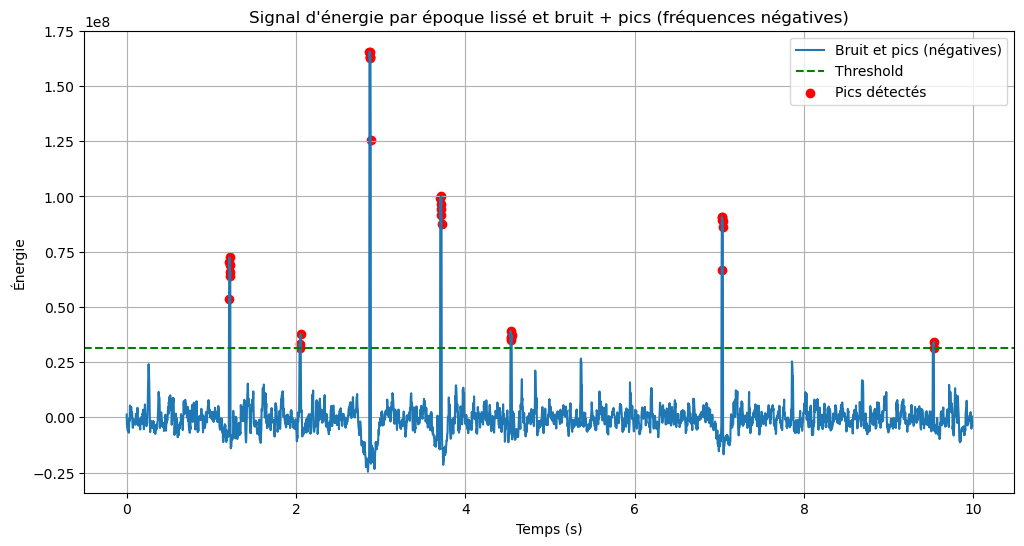

Positions des pics détectés : [1.20895862 1.21191451 1.2148704  1.21782628 1.22078217 1.22373806
 2.04251933 2.04547522 2.05434288 2.86721237 2.87016826 2.87312415
 2.87608004 2.87903593 2.88199181 3.70372897 3.70668486 3.70964075
 3.71259663 3.71555252 3.71850841 4.53433379 4.53728968 4.54024557
 4.54320146 4.54615734 7.02614825 7.02910414 7.03206003 7.03501592
 7.03797181 7.04092769 9.52978627 9.53274216]


In [12]:
# Détection des pics dans noise_and_peaks_neg en utilisant le 95e centile
threshold = np.percentile(noise_and_peaks_neg, 99)
peaks_indices = np.where(noise_and_peaks_neg > threshold)[0]

# Affichage des points supérieurs au lissage pour les fréquences négatives
plt.figure(figsize=(12, 6))
plt.plot(epoch_times, noise_and_peaks_neg, label='Bruit et pics (négatives)')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')  # Ajout de la ligne pour le seuil
plt.scatter(epoch_times[peaks_indices], noise_and_peaks_neg[peaks_indices], color='red', label='Pics détectés')
plt.xlabel('Temps (s)')
plt.ylabel('Énergie')
plt.title('Signal d\'énergie par époque lissé et bruit + pics (fréquences négatives)')
plt.legend()
plt.grid(True)
plt.show()

# Enregistrement des positions des pics détectés
peaks_positions_neg = epoch_times[peaks_indices]
print("Positions des pics détectés :", peaks_positions_neg)

# XII. Sélection des Pics Pertinents

Dans cette partie du code, nous traitons les pics détectés pour les fréquences négatives afin de sélectionner ceux qui sont suffisamment espacés dans le temps pour être considérés comme distincts.

- **Tri des Positions :** Nous commençons par trier les positions des pics détectés dans `peaks_positions_neg` par ordre croissant, afin de faciliter le traitement ultérieur.
  
- **Définition de la Fenêtre Temporelle :** Nous définissons une fenêtre temporelle autour de chaque pic, avec une taille fixe de 0.1 unité de temps.
  
- **Sélection des Pics :** Nous parcourons ensuite les positions des pics triés. Pour chaque position de pic, nous comptons le nombre de pics qui se trouvent dans la fenêtre temporelle autour de cette position. Si le nombre de pics dans cette fenêtre est supérieur ou égal à 3, nous considérons que le pic est suffisamment isolé et nous le conservons dans la liste `selected_peaks`.
  
- **Affichage des Pics Sélectionnés :** Enfin, nous affichons les positions des pics sélectionnés dans la variable `selected_peaks`.


In [13]:
# Trier les positions des pics détectés
sorted_peaks_positions_neg = np.sort(peaks_positions_neg)

# Fenêtre temporelle autour de chaque pic
window_size = 0.1

# Liste pour stocker les pics à conserver
selected_peaks = []

# Parcourir les positions des pics
for i, peak_pos in enumerate(sorted_peaks_positions_neg):
    # Compter le nombre de pics dans la fenêtre temporelle autour de peak_pos
    num_peaks_in_window = np.sum(np.abs(sorted_peaks_positions_neg - peak_pos) < window_size)
    # Si le nombre de pics dans la fenêtre est >= 3, les conserver
    if num_peaks_in_window >= 3:
        selected_peaks.append(peak_pos)

# Afficher les pics sélectionnés
print("Pics sélectionnés :", selected_peaks)

Pics sélectionnés : [1.2089586175534335, 1.2119145065939063, 1.2148703956343794, 1.2178262846748522, 1.2207821737153253, 1.223738062755798, 2.0425193269668034, 2.045475216007276, 2.054342883128695, 2.867212369258754, 2.870168258299227, 2.8731241473397002, 2.876080036380173, 2.879035925420646, 2.8819918144611187, 3.703728967712597, 3.70668485675307, 3.7096407457935427, 3.7125966348340156, 3.715552523874489, 3.7185084129149617, 4.534333788085494, 4.537289677125966, 4.54024556616644, 4.543201455206913, 4.546157344247385, 7.0261482492041845, 7.029104138244657, 7.03206002728513, 7.035015916325603, 7.037971805366076, 7.040927694406549]


### Le code suivant est le même que celui en partie IV. c'est juste pour avoir un élément de comparaison pour la slide d'après

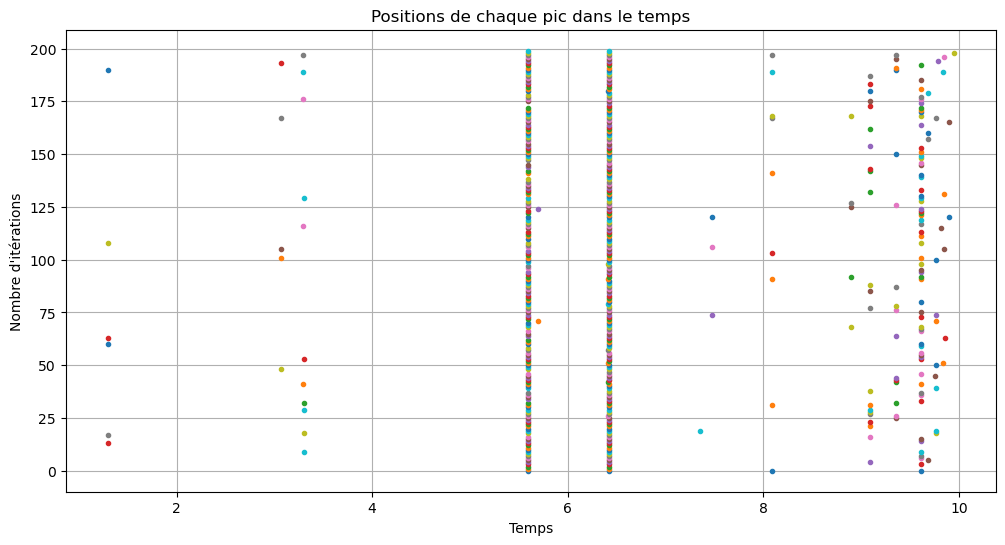

Nombre d'embolies: 2
Positions des embolies: [4.957025920873124, 5.908822191905412]


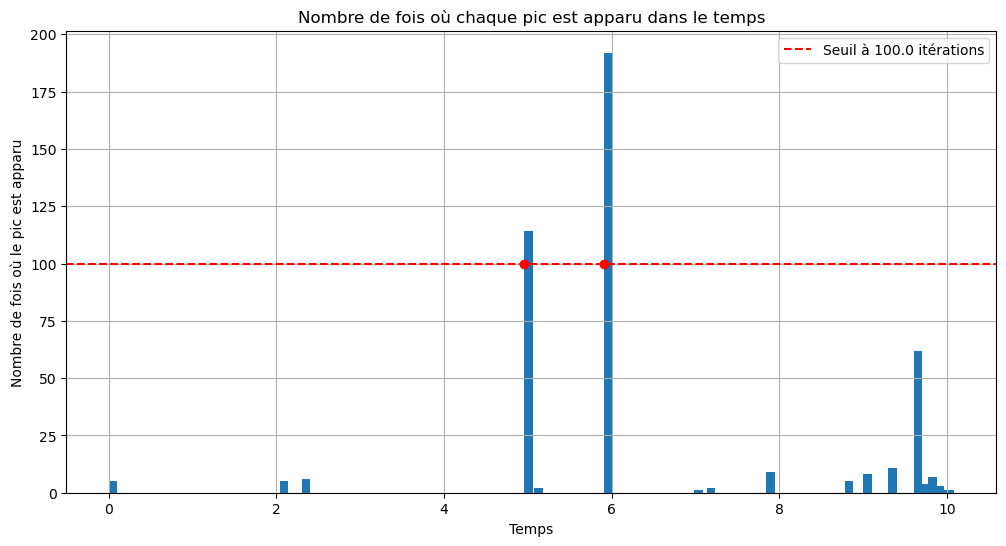

In [14]:
plt.figure(figsize=(12, 6))
for i, positions in enumerate(pic_positions):
    plt.plot(epoch_times[positions], [i] * len(positions), '.')
plt.xlabel('Temps')
plt.ylabel('Nombre d\'itérations')
plt.title('Positions de chaque pic dans le temps')
plt.grid(True)
plt.show()

# Définir le seuil d'itérations
seuil_iterations = iteration/2

print(f"Nombre d'embolies: {nombre_embolies}")
print(f"Positions des embolies: {embolies_positions}")

# Afficher les positions de chaque pic dans le temps par rapport au nombre de fois où le pic est apparu
plt.figure(figsize=(12, 6))
plt.bar(epoch_times, position_counts, width=0.1, align='edge')

# Ajouter une ligne horizontale à la position du seuil (nombre d'itérations)
plt.axhline(y=seuil_iterations, color='red', linestyle='--', label=f'Seuil à {seuil_iterations} itérations')

# Ajouter des petits cercles en haut des barres qui dépassent le seuil
for embolie_pos in embolies_positions:
    plt.plot(embolie_pos, seuil_iterations, 'ro')

plt.xlabel('Temps')
plt.ylabel('Nombre de fois où le pic est apparu')
plt.title('Nombre de fois où chaque pic est apparu dans le temps')
plt.legend()
plt.grid(True)
plt.show()

# XIII. Supression des artefacts qui correspondent à des embolies

In [15]:
# Supprimer les embolies correspondant à des pics supérieurs au seuil
embolies_positions = [embolie for embolie in embolies_positions if embolie not in selected_peaks]

# Afficher les embolies restantes
print("Positions des embolies après filtrage avec les artefacts :", embolies_positions)

Positions des embolies après filtrage avec les artefacts : [4.957025920873124, 5.908822191905412]
